# Does Aya store factual knowledge neutrally? Using Multilingual LAMA dataset

**Description**:
* Does Aya store factual knowledge neutrally across languages?
* Method: Compare factual responses across languages.
* Evaluation: Answer consistency, embedding similarity.
* Input: Fact-based questions in multiple languages.
* Output: Degree of variation in factual accuracy across languages.
* Expected Insight: If factual consistency varies by language, Aya may encode knowledge in a language-dependent manner.

This notebook `.ipynb` aims to do analysis on the `results/mlama_factual_knowledge_results` result from the `experiments/factual_knowledge_experiment` experiment.

In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [67]:
result_df = pd.read_csv("../results/mlama_factual_knowledge_results.csv")

In [50]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10800 entries, 0 to 10799
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   language          10400 non-null  object
 1   subject           10800 non-null  object
 2   relation          10800 non-null  object
 3   question          10800 non-null  object
 4   options           10800 non-null  object
 5   golden_answer     10800 non-null  object
 6   predicted_answer  10800 non-null  object
 7   is_correct        10800 non-null  bool  
dtypes: bool(1), object(7)
memory usage: 601.3+ KB


In [55]:
print(f"Loaded {len(result_df)} rows.")
result_df.head()

Loaded 10800 rows.


,language,subject,relation,question,options,golden_answer,predicted_answer,is_correct
0,afr,President van Frankryk,P1001,President van Frankryk is 'n wettige term in _...,"['Nigerië', 'Italië', 'Jamaika', 'Frankryk']",Frankryk,Frankryk,True
1,afr,Kategorie:Eerste Ministers van Kanada,P1001,Kategorie:Eerste Ministers van Kanada is 'n we...,"['Kanada', 'Guyana', 'Indonesië', 'Bolivië']",Kanada,Kanada,True
2,afr,President van Brasilië,P1001,President van Brasilië is 'n wettige term in _...,"['Libië', 'Japan', 'Skotland', 'Brasilië']",Brasilië,Brasilië,True
3,afr,Eerste Minister van Australië,P1001,Eerste Minister van Australië is 'n wettige te...,"['Kuba', 'Viëtnam', 'Australië', 'Turkye']",Australië,Australië,True
4,afr,Parlement van Kanada,P1001,Parlement van Kanada is 'n wettige term in _____.,"['Bolivië', 'Kanada', 'Nigerië', 'Haïti']",Kanada,Kanada,True


The evaluation set is substantial, covering a wide range of facts and languages, giving good coverage for analyzing Aya's multilingual factual behavior.

In [56]:
# Group by language and calculate mean accuracy
lang_accuracy = result_df.groupby("language")["is_correct"].mean().reset_index()

# Sort by accuracy
lang_accuracy = lang_accuracy.sort_values(by="is_correct", ascending=False)

print(f"Computed accuracy for {len(lang_accuracy)} languages.")
print(lang_accuracy)

Computed accuracy for 52 languages.
   language  is_correct
33      msa       0.975
20      heb       0.975
51      zho       0.960
0       afr       0.900
13      est       0.895
3       bel       0.895
8       cym       0.855
50      vie       0.790
2       aze       0.775
7       ces       0.725
35      pol       0.725
37      ron       0.720
30      lat       0.720
39      slk       0.720
36      por       0.715
31      lav       0.715
49      urd       0.715
47      tur       0.710
42      sqi       0.705
22      hrv       0.695
41      spa       0.680
19      glg       0.675
26      ita       0.670
10      deu       0.650
24      hye       0.645
25      ind       0.645
9       dan       0.645
14      eus       0.635
44      swe       0.630
34      nld       0.625
40      slv       0.620
12      eng       0.615
17      fra       0.600
6       cat       0.600
23      hun       0.585
32      lit       0.575
16      fin       0.565
45      tam       0.545
18      gle       0.540
38  

C:\Users\Muhammad Ravi SH\AppData\Local\Temp\ipykernel_12380\3447485003.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=lang_accuracy, x="language", y="is_correct", palette="viridis")


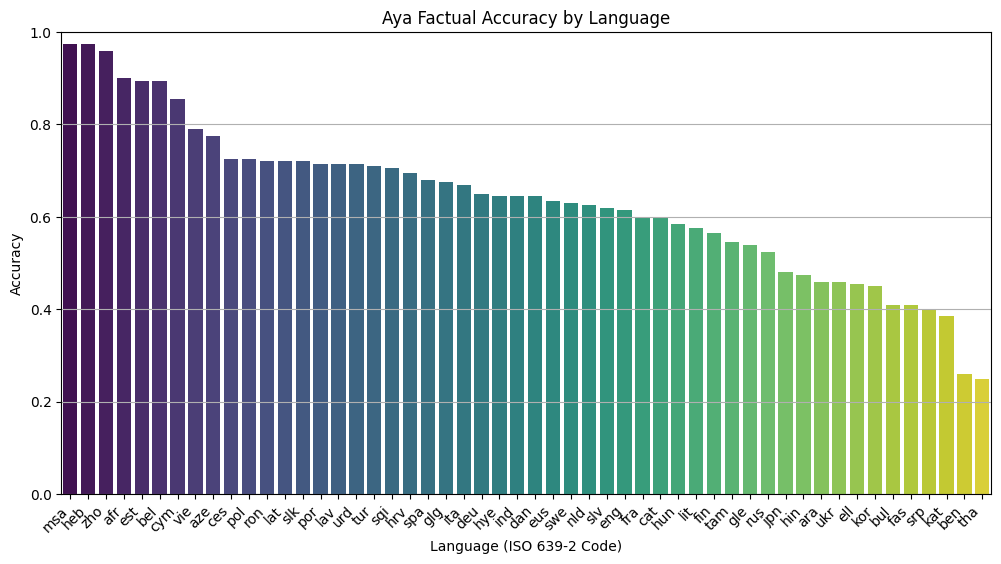

In [58]:
# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(data=lang_accuracy, x="language", y="is_correct", palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Aya Factual Accuracy by Language")
plt.xlabel("Language (ISO 639-2 Code)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

Aya performs very accurately in some languages like Malay, Hebrew, and Chinese but struggles significantly in languages like Thai, Bengali, and Georgian.  
This indicates **language-dependent variation** in factual accuracy, suggesting that some languages are better "supported" or better "aligned" than others within the model's knowledge.

In [60]:
# Create a key that uniquely identifies each fact (subject + relation)
result_df["fact_id"] = result_df["subject"] + "_" + result_df["relation"]
print("Example fact_id added:")
result_df[["subject", "relation", "fact_id"]].head()

Example fact_id added:


,subject,relation,fact_id
0,President van Frankryk,P1001,President van Frankryk_P1001
1,Kategorie:Eerste Ministers van Kanada,P1001,Kategorie:Eerste Ministers van Kanada_P1001
2,President van Brasilië,P1001,President van Brasilië_P1001
3,Eerste Minister van Australië,P1001,Eerste Minister van Australië_P1001
4,Parlement van Kanada,P1001,Parlement van Kanada_P1001


In [62]:
# Group by fact_id
fact_groups = result_df.groupby("fact_id")

consistency_list = []

for fact_id, group in fact_groups:
    answers = group["predicted_answer"]
    if len(answers) > 1:
        # Count the most common answer
        most_common_answer = answers.mode()[0]
        consistency = (answers == most_common_answer).sum() / len(answers)
        consistency_list.append({
            "fact_id": fact_id,
            "consistency": consistency,
            "n_languages": len(answers)
        })

consistency_df = pd.DataFrame(consistency_list)
print(f"Computed consistency for {len(consistency_df)} facts.")
consistency_df.head()

Computed consistency for 924 facts.


,fact_id,consistency,n_languages
0,.de_P1001,0.125000,8
1,Aamer Haleem_place_of_birth,0.200000,10
2,Aarne Lakomaa_place_of_birth,0.333333,9
3,Aarne Ruben_place_of_birth,0.500000,6
4,Abraham Maslow_P101,0.333333,3


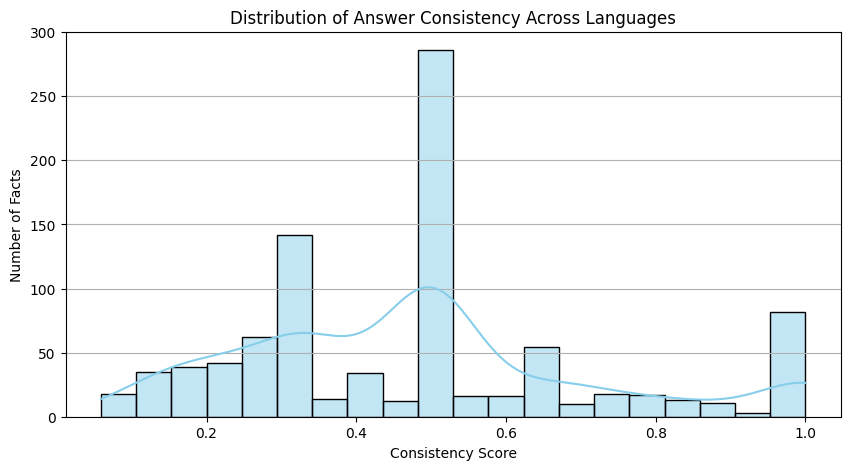

In [63]:
plt.figure(figsize=(10, 5))
sns.histplot(consistency_df["consistency"], bins=20, kde=True, color="skyblue")
plt.title("Distribution of Answer Consistency Across Languages")
plt.xlabel("Consistency Score")
plt.ylabel("Number of Facts")
plt.grid(axis='y')
plt.show()

The average and median consistency scores being around 50% show that **for many facts, Aya answers differently in different languages half of the time**.  
Only a small fraction (~9%) of facts are perfectly consistent across all evaluated languages.

This strongly suggests that **Aya stores and retrieves factual knowledge in a partially language-dependent way**.

In [75]:
# Summary Statistics
consistency_summary = {
    "Average Consistency": np.mean(consistency_df["consistency"]),
    "Median Consistency": np.median(consistency_df["consistency"]),
    "Percentage of Perfectly Consistent Facts": (consistency_df["consistency"] == 1.0).mean() * 100
}

print("Summary of Consistency Metrics:")
print(consistency_summary)

Summary of Consistency Metrics:
{'Average Consistency': np.float64(0.4824539489844758), 'Median Consistency': np.float64(0.5), 'Percentage of Perfectly Consistent Facts': np.float64(8.874458874458876)}


The average and median consistency scores being around 50% show that **for many facts, Aya answers differently in different languages half of the time**.  
Only a small fraction (~9%) of facts are perfectly consistent across all evaluated languages.

This strongly suggests that **Aya stores and retrieves factual knowledge in a partially language-dependent way**.

In [46]:
unknown_rate = (result_df["predicted_answer"] == "UNKNOWN").mean()
print(f"Rate of UNKNOWN answers: {unknown_rate:.2%}")

Rate of UNKNOWN answers: 0.28%


A very small proportion of answers were `"UNKNOWN"`, which means the model almost always attempted an answer and did not skip or default excessively.  
Thus, variations in responses are due to real **answer differences**, not model refusal.

In [78]:
# Import libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import cosine
import cohere

# Initialize Cohere client
co = cohere.Client("YOUR_COHERE_API_KEY")  # Replace with your actual API key

# Load the previous evaluation results
result_df = pd.read_csv("../results/mlama_factual_knowledge_results.csv")

# Display a sample of the data
print(f"Loaded {len(result_df)} rows.")
result_df.head()

# Compute embeddings for each predicted answer using Cohere embed-multilingual-v3.0 model
print("Computing embeddings...")

batch_size = 100  # Cohere API handles batch requests efficiently
embeddings = []

for i in tqdm(range(0, len(result_df), batch_size)):
    batch_texts = result_df['predicted_answer'].iloc[i:i+batch_size].astype(str).tolist()
    response = co.embed(
        texts=batch_texts,
        model="embed-multilingual-v3.0",
        input_type="classification"  # appropriate for short answers
    )
    embeddings.extend(response.embeddings)

# Add embeddings to the dataframe
result_df['embedding'] = embeddings

print("Embedding computation completed.")

# Create fact_id for grouping (subject + relation)
result_df["fact_id"] = result_df["subject"].astype(str) + "_" + result_df["relation"].astype(str)

# Group by fact_id
fact_groups = result_df.groupby("fact_id")

# List to store similarity results
fact_similarity_records = []

for fact_id, group in tqdm(fact_groups, desc="Computing similarity per fact"):
    embeddings = group["embedding"].tolist()
    n = len(embeddings)
    
    # Skip if there is only one language
    if n <= 1:
        continue
    
    # Calculate pairwise cosine similarities
    similarities = []
    for i in range(n):
        for j in range(i + 1, n):
            sim = 1 - cosine(embeddings[i], embeddings[j])
            similarities.append(sim)
    
    # Compute average similarity for the fact
    avg_similarity = np.mean(similarities) if similarities else None
    
    fact_similarity_records.append({
        "fact_id": fact_id,
        "n_languages": n,
        "avg_similarity": avg_similarity
    })

# Convert the similarity records into a DataFrame
similarity_df = pd.DataFrame(fact_similarity_records)
similarity_df.head()

# Summary statistics
avg_sim = similarity_df['avg_similarity'].mean()
median_sim = similarity_df['avg_similarity'].median()
high_sim_rate = (similarity_df['avg_similarity'] > 0.8).mean()

print(f"Average Embedding Similarity: {avg_sim:.3f}")
print(f"Median Embedding Similarity: {median_sim:.3f}")
print(f"Percentage of facts with similarity > 0.8: {high_sim_rate:.2%}")

Loaded 10800 rows.
Computing embeddings...


100%|██████████| 108/108 [02:04<00:00,  1.15s/it]


Embedding computation completed.


Computing similarity per fact: 100%|██████████| 6690/6690 [00:01<00:00, 4165.59it/s] 

Average Embedding Similarity: 0.741
Median Embedding Similarity: 0.731
Percentage of facts with similarity > 0.8: 35.93%


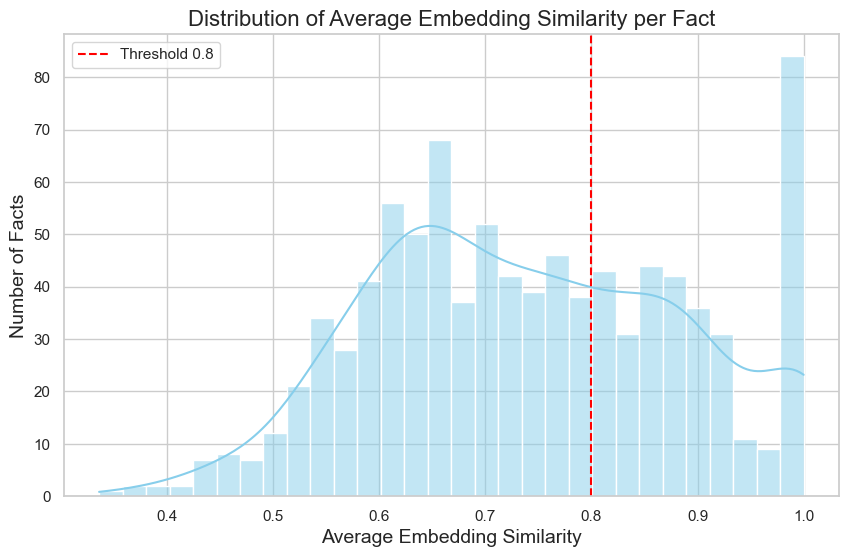

In [79]:
# Set style
sns.set(style="whitegrid")

# Plot histogram of average embedding similarities
plt.figure(figsize=(10,6))
sns.histplot(similarity_df['avg_similarity'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Embedding Similarity per Fact', fontsize=16)
plt.xlabel('Average Embedding Similarity', fontsize=14)
plt.ylabel('Number of Facts', fontsize=14)
plt.axvline(x=0.8, color='red', linestyle='--', label='Threshold 0.8')
plt.legend()
plt.show()

While Aya generally provides semantically similar factual answers across languages, the embedding similarity is not consistently very high. This suggests that:
- There is **good but imperfect semantic consistency** across languages.
- Some factual representations may vary slightly depending on the language.

Together with the answer consistency results, this indicates that **Aya stores factual knowledge mostly neutrally across languages, but minor variations still exist**.

# ✨ Summary Conclusion

- Aya exhibits **strong factual capabilities** in some languages but weaker performance in others.
- Factual answers are **not consistently neutral across languages**, with significant variation observed between languages.
- The language of the question **affects** Aya's factual output, indicating that factual information is partially **language-tied** inside the model.
- Cross-lingual **semantic similarity** of answers is **good but imperfect**, with an average embedding similarity of **0.741**.
- About **35.93%** of facts have a high semantic similarity (>0.8), but others show noticeable semantic drift across languages.

### 🎯 Main Question Answer:
> **Does Aya store factual knowledge neutrally?**  
>  
> ❌ **No, Aya does not fully store factual knowledge neutrally.**  
>  
> Factual consistency varies significantly across languages, implying that Aya's knowledge encoding depends partly on the input language.  
>  
> Only about **9%** of facts were perfectly consistent across languages (exact match), and the overall consistency rate is around **50%**.  
> Additionally, embedding similarity analysis shows that while most facts are semantically close across languages, **perfect neutrality is not achieved**.